## Test the Stability of the Model
In this experiment, we check the stability of the model by performing the following experiments: 
1. Remove 5% - 10% of data randomly from the training set and evaluate the testing performance

In [3]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import clone
from sklearn.metrics import r2_score

from src.load_dataset import load_dataset
from src.utils import tsen_pca_viz, verify_batch_label_dist, calculate_r2_score, calculate_per_diff, per_error, find_adj_score, perform_combat_normalization
from src.load_models import select_model
from src.graph_visualization import visualization_testing_dataset
from src.config import *

In [4]:
# Load dataset
normalization    = True
standardize_type = 'mean_std' if normalization else 'none'
split            = False
combat_norm      = True
data_per_remove  = 5

ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split)
ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split)
ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split)

In [5]:
# Perform stratified train test split
X                = pd.concat([ML1_X, ML2_X, ML4_X], axis=0)
y                = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()
stratified_label = ML1_y.map(lambda x: f'ML1_{x}').values.tolist() + ML2_y.map(lambda x: f'ML2_{x}').values.tolist() + ML4_y.map(lambda x: f'ML4_{x}').values.tolist()

X_train, X_test, y_train_strat, y_test_strat = train_test_split(X, stratified_label, test_size=0.4, shuffle=True, random_state=20, stratify=stratified_label)
y_train, y_test = pd.Series(y_train_strat).map(lambda x: eval(x.split('_')[1])), pd.Series(y_test_strat).map(lambda x: eval(x.split('_')[1]))

In [45]:
def plot_scores_distribution(scores, model_name):
    scores = scores.copy()
    if type(scores[5][model_name][0])==tuple:
        for data_per_remove in per_to_remove:
            scores[data_per_remove][model_name] = np.array(scores[data_per_remove][model_name])[:,0]
    for data_per_remove in per_to_remove:
        sns.kdeplot(scores[data_per_remove][model_name], label=f'{data_per_remove}%')
    
    plt.legend(title='Parameter', title_fontsize='13')
    plt.show()


def training_reduction_plot(scores, model_names, r2=True):
    

    min_, max_ = (0.70 if r2 else 10), (0.9 if r2 else 60)
    
    for model_name in model_names:
        data = []
        if type(scores[5][model_name][0])==tuple:
            for data_per_remove in per_to_remove:
                scores[data_per_remove][model_name] = np.array(scores[data_per_remove][model_name])[:,0]
    
        for data_per_remove in per_to_remove:
            data.append(scores[data_per_remove][model_name].mean())
            
        # plt.ylim(bottom=min_, top=max_)
        plt.plot(data, label=model_name)
        plt.xticks(ticks=range(len(per_to_remove)), labels=[f'{i}%' for i in per_to_remove])
        plt.legend()
        
    plt.show()

def box_plot(scores, model_names):
    for model_name in model_names:
        data = pd.DataFrame(columns=['scores', 'per_remove'])
        if type(scores[5][model_name][0])==tuple:
            for data_per_remove in per_to_remove:
                scores[data_per_remove][model_name] = np.array(scores[data_per_remove][model_name])[:,0]
    
        for data_per_remove in per_to_remove:
            temp = pd.DataFrame({'scores':scores[data_per_remove][model_name].tolist(), 'per_remove':[f'{data_per_remove}%']*len(scores[data_per_remove][model_name])})
            data = pd.concat([data, temp], axis=0)
            
        sns.boxplot(x='per_remove', y='scores', data=data)
        plt.title(f'{model_name}')
        plt.show()
        
    
    

In [8]:
# List of models
models        = ['Linear', 'KNN', 'SVM', 'RF', 'GP', 'Ridge', 'Lasso', 'univariate, std(S)', 'univariate, max(dS/dV)', 'univariate, area(dS/dV)', 'univariate, area(S)', 'univariate, max(S)']
per_to_remove = [5, 10, 20, 30, 50]
num_iteration = 100

# Calcualte y_LOD
y_LOD = 0.9117010154341669 #calculate_y_LOD(X_testing, y_testing)
#print("y_LOD", y_LOD)

kf = KFold(n_splits=5)

r2_score_val,  per_diff_val  = {}, {}
r2_score_test, per_diff_test = {}, {}

for data_per_remove in per_to_remove:
    r2_score_val[data_per_remove], per_diff_val[data_per_remove], r2_score_test[data_per_remove], per_diff_test[data_per_remove] = {}, {}, {}, {} 
    for model_name in models:
        r2_score_val[data_per_remove][model_name]  = []
        per_diff_val[data_per_remove][model_name]  = [] 
        r2_score_test[data_per_remove][model_name] = [] 
        per_diff_test[data_per_remove][model_name] = [] 
         
for data_per_remove in per_to_remove:
    for _ in range(num_iteration):
        num_selection = int((100 - data_per_remove) * len(y_train) / 100.0)
        selected_indx = np.random.choice(range(len(y_train) - 1), num_selection)
        
        X_train_      = X_train.iloc[selected_indx]
        y_train_      = y_train.iloc[selected_indx]
    
        assert len(y_train_) == num_selection
    
        print(X_train_.shape)
        
        for model_name in models:
            model    = select_model(model_name)
        
            val_r2     = calculate_r2_score(model, X_train_[models_features_r2[model_name]],  y_train_, kf)
            val_per    = calculate_per_diff(model, X_train_[models_features_per[model_name]], y_train_, kf, y_LOD)
        
            r2_score_val[data_per_remove][model_name].append((float(val_r2[0]), float(val_r2[1])))
            per_diff_val[data_per_remove][model_name].append(float(val_per))
        
            model_r2  = clone(model)
            model_r2.fit(X_train_[models_features_r2[model_name]], y_train_)
            y_pred_r2 = model_r2.predict(X_test[models_features_r2[model_name]])
        
            r2_test_score = r2_score(y_test, y_pred_r2)
            adj_r2_test   = find_adj_score(len(y_pred_r2), len(models_features_r2[model_name]), r2_test_score)
            
            r2_score_test[data_per_remove][model_name].append((float(r2_test_score), float(adj_r2_test)))
        
            model_per_diff = clone(model)
            model_per_diff.fit(X_train_[models_features_per[model_name]], y_train_)
            y_pred_per_diff = model_per_diff.predict(X_test[models_features_per[model_name]])
            
            per_diff_test[data_per_remove][model_name].append(per_error(y_test, y_pred_per_diff, y_LOD))


(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.245e+01, tolerance: 7.360e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.319e+02, tolerance: 7.678e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+02, tolerance: 7.154e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.917e+01, tolerance: 6.844e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e+00, tolerance: 7.232e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.190e+01, tolerance: 7.072e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.882e+01, tolerance: 6.910e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.167e+01, tolerance: 7.112e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.246e+00, tolerance: 7.162e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e+01, tolerance: 7.294e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e+02, tolerance: 6.676e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.981e+02, tolerance: 6.887e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e+02, tolerance: 6.445e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e+00, tolerance: 6.588e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.443e+02, tolerance: 6.308e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.448e+02, tolerance: 6.884e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.958e+02, tolerance: 7.185e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.577e+02, tolerance: 6.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.419e+01, tolerance: 6.778e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+01, tolerance: 6.417e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e+02, tolerance: 6.375e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e+02, tolerance: 6.526e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e+02, tolerance: 6.650e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+02, tolerance: 6.336e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+02, tolerance: 6.863e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.050e+01, tolerance: 6.898e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+02, tolerance: 7.228e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.587e+01, tolerance: 6.829e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.452e+01, tolerance: 6.548e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.371e+01, tolerance: 6.436e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.558e+01, tolerance: 7.606e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.800e+00, tolerance: 7.360e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e+02, tolerance: 6.812e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.946e+02, tolerance: 6.976e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+02, tolerance: 7.469e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.479e+01, tolerance: 7.418e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.340e+02, tolerance: 7.104e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+02, tolerance: 7.129e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e+02, tolerance: 6.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.403e+02, tolerance: 7.094e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.415e+02, tolerance: 7.488e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.511e+00, tolerance: 7.257e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.059e+02, tolerance: 6.270e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.204e+02, tolerance: 6.528e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.276e+02, tolerance: 7.166e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e+01, tolerance: 7.469e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e+01, tolerance: 7.282e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.847e+01, tolerance: 7.268e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.778e+01, tolerance: 7.426e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.350e+01, tolerance: 7.584e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.576e+02, tolerance: 6.632e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.388e+02, tolerance: 6.600e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e+02, tolerance: 7.143e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.463e+00, tolerance: 6.910e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.505e+02, tolerance: 6.966e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e+02, tolerance: 7.399e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.567e+01, tolerance: 6.760e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e+02, tolerance: 6.735e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e+02, tolerance: 7.360e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+02, tolerance: 6.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+02, tolerance: 6.856e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.919e+02, tolerance: 6.745e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.027e+00, tolerance: 6.560e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.555e+00, tolerance: 6.906e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e+02, tolerance: 7.550e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.392e+01, tolerance: 7.290e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+02, tolerance: 7.104e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e+02, tolerance: 7.001e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.351e+01, tolerance: 6.964e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.969e+00, tolerance: 7.257e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e+02, tolerance: 6.912e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.800e+02, tolerance: 7.104e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e+00, tolerance: 6.984e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.055e+00, tolerance: 7.257e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.099e+01, tolerance: 7.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e+00, tolerance: 6.898e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.211e+02, tolerance: 6.778e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.208e+02, tolerance: 6.888e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e+01, tolerance: 6.560e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e+01, tolerance: 6.760e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.788e+00, tolerance: 6.745e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.737e+01, tolerance: 7.026e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.007e+02, tolerance: 7.143e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.126e+02, tolerance: 6.707e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.778e+02, tolerance: 8.081e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.601e+02, tolerance: 8.058e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e+02, tolerance: 6.884e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.568e+02, tolerance: 6.526e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.464e+02, tolerance: 6.884e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.731e+02, tolerance: 7.040e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.418e+01, tolerance: 7.708e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.383e+01, tolerance: 7.725e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e+01, tolerance: 7.725e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e+01, tolerance: 7.100e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e+02, tolerance: 7.085e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e+02, tolerance: 7.282e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e+01, tolerance: 7.290e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.609e+00, tolerance: 7.085e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.283e+02, tolerance: 7.744e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e+02, tolerance: 7.527e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.894e+00, tolerance: 7.166e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.824e+00, tolerance: 6.910e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.167e+01, tolerance: 7.368e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.731e+01, tolerance: 6.910e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.855e+02, tolerance: 6.782e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e+02, tolerance: 6.592e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.006e+02, tolerance: 7.348e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+02, tolerance: 7.546e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.574e+01, tolerance: 7.360e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.000e+02, tolerance: 7.597e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e+02, tolerance: 6.375e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+02, tolerance: 6.642e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.297e+02, tolerance: 7.001e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.341e+02, tolerance: 6.804e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.767e+02, tolerance: 6.829e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.235e+02, tolerance: 7.001e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.772e+02, tolerance: 7.129e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.711e+02, tolerance: 6.914e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.219e+02, tolerance: 6.984e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e+02, tolerance: 7.034e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.032e+02, tolerance: 6.914e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.076e+02, tolerance: 6.708e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.551e+02, tolerance: 6.944e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+02, tolerance: 6.966e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e+00, tolerance: 7.094e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e+02, tolerance: 6.631e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.816e+02, tolerance: 7.328e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.237e+02, tolerance: 7.478e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.282e+02, tolerance: 7.104e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.800e+00, tolerance: 7.100e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e+02, tolerance: 6.701e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.360e+01, tolerance: 6.848e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.544e+02, tolerance: 7.444e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.303e+02, tolerance: 7.836e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.243e+01, tolerance: 6.929e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.156e+01, tolerance: 6.745e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.023e+02, tolerance: 6.402e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.452e+02, tolerance: 6.631e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.435e+02, tolerance: 7.104e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e+02, tolerance: 7.624e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+01, tolerance: 7.350e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.787e+00, tolerance: 7.527e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.449e+01, tolerance: 6.735e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.815e+00, tolerance: 6.654e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e+01, tolerance: 6.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.153e+01, tolerance: 7.478e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+02, tolerance: 7.038e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.683e+02, tolerance: 6.848e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.181e+02, tolerance: 7.360e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.730e+02, tolerance: 7.294e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+02, tolerance: 6.582e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.430e+01, tolerance: 6.592e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.862e+00, tolerance: 7.038e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e+00, tolerance: 6.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+02, tolerance: 7.144e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.774e+02, tolerance: 7.538e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e+02, tolerance: 7.538e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e+02, tolerance: 7.350e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.128e+02, tolerance: 6.976e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.434e+02, tolerance: 6.701e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e+02, tolerance: 6.888e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.490e+01, tolerance: 6.838e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.821e+02, tolerance: 6.966e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.672e+01, tolerance: 7.162e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.636e+01, tolerance: 7.922e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.555e+01, tolerance: 7.912e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e+02, tolerance: 7.597e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.486e+02, tolerance: 7.981e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e+02, tolerance: 6.707e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.560e+01, tolerance: 6.723e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.874e+02, tolerance: 7.294e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e+02, tolerance: 7.538e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e+02, tolerance: 7.257e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.228e+01, tolerance: 7.162e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.624e+02, tolerance: 6.673e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e+02, tolerance: 6.786e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e+02, tolerance: 7.220e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.810e+01, tolerance: 7.085e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e+02, tolerance: 6.887e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.970e+01, tolerance: 6.617e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e+02, tolerance: 6.631e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.866e+02, tolerance: 6.398e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.065e+01, tolerance: 7.328e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.407e+00, tolerance: 7.100e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e+02, tolerance: 7.154e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.312e+02, tolerance: 6.912e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.048e+00, tolerance: 6.514e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e+01, tolerance: 6.838e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+01, tolerance: 6.844e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e+02, tolerance: 6.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.145e+00, tolerance: 6.976e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.941e+00, tolerance: 6.910e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.923e+02, tolerance: 7.422e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.264e+02, tolerance: 7.368e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e+01, tolerance: 6.579e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.563e+00, tolerance: 6.851e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.269e+02, tolerance: 7.162e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.789e+02, tolerance: 7.424e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(205, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+02, tolerance: 7.368e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e+02, tolerance: 7.422e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.440e+01, tolerance: 6.462e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.827e+02, tolerance: 6.674e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.176e+01, tolerance: 7.038e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.209e+01, tolerance: 6.601e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.253e+00, tolerance: 6.473e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e+02, tolerance: 6.208e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.326e+02, tolerance: 7.182e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.768e+00, tolerance: 7.241e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 6.782e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e+02, tolerance: 6.687e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e+02, tolerance: 6.934e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.166e+01, tolerance: 6.447e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.068e+01, tolerance: 6.542e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.170e+00, tolerance: 6.398e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e+02, tolerance: 6.910e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.644e+01, tolerance: 7.166e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e+02, tolerance: 7.674e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e+02, tolerance: 7.606e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e+02, tolerance: 6.905e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.742e+02, tolerance: 6.897e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.895e+01, tolerance: 6.798e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e+01, tolerance: 6.588e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.046e+02, tolerance: 6.883e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.725e+02, tolerance: 7.109e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e+01, tolerance: 7.488e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.338e+02, tolerance: 7.127e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.493e+01, tolerance: 6.246e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.285e+00, tolerance: 6.138e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.940e+02, tolerance: 6.678e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.284e+02, tolerance: 6.542e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e+02, tolerance: 6.547e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.177e+02, tolerance: 6.584e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.036e+00, tolerance: 6.374e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e+01, tolerance: 6.246e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e+02, tolerance: 7.033e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.540e+02, tolerance: 6.641e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.088e+01, tolerance: 6.716e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e+01, tolerance: 6.398e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e+02, tolerance: 6.115e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.406e+01, tolerance: 6.670e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.707e+02, tolerance: 6.575e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e+02, tolerance: 6.315e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.976e+01, tolerance: 6.129e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.818e+02, tolerance: 6.014e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.621e+02, tolerance: 6.137e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+02, tolerance: 6.016e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.868e+02, tolerance: 6.769e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.168e+01, tolerance: 6.393e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e+02, tolerance: 7.025e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.055e+02, tolerance: 6.777e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.091e+02, tolerance: 6.394e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.320e+02, tolerance: 6.550e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+02, tolerance: 6.265e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.310e+02, tolerance: 5.948e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e+02, tolerance: 6.838e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.865e+02, tolerance: 6.956e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.901e+02, tolerance: 7.094e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.714e+02, tolerance: 7.139e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.170e+02, tolerance: 6.460e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+02, tolerance: 6.502e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.428e+02, tolerance: 6.118e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e+01, tolerance: 6.487e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.924e+01, tolerance: 5.822e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.111e+01, tolerance: 6.345e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e+01, tolerance: 6.716e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.205e+01, tolerance: 6.414e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e+02, tolerance: 6.257e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.830e+01, tolerance: 6.601e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e+01, tolerance: 6.588e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.441e+02, tolerance: 6.487e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.381e+02, tolerance: 7.104e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.549e+02, tolerance: 7.212e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.152e+02, tolerance: 7.281e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.582e+02, tolerance: 7.241e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.335e+01, tolerance: 6.137e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e+02, tolerance: 5.829e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.706e+00, tolerance: 6.886e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.284e+01, tolerance: 6.802e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+02, tolerance: 6.703e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.215e+02, tolerance: 6.828e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.135e+02, tolerance: 6.001e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.456e+01, tolerance: 6.316e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e+02, tolerance: 5.663e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.395e+02, tolerance: 5.686e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.743e+01, tolerance: 6.966e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.814e+01, tolerance: 7.360e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.860e+00, tolerance: 6.838e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.219e+01, tolerance: 6.400e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.015e+02, tolerance: 6.725e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e+02, tolerance: 6.414e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.432e+01, tolerance: 6.601e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e+02, tolerance: 7.127e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+01, tolerance: 6.976e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.345e+01, tolerance: 6.943e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e+02, tolerance: 6.502e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e+02, tolerance: 6.473e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.001e+02, tolerance: 6.641e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e+02, tolerance: 6.743e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.458e+02, tolerance: 6.400e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.208e+02, tolerance: 6.246e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.259e+02, tolerance: 6.359e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.034e+02, tolerance: 6.198e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.514e+01, tolerance: 6.385e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.265e+02, tolerance: 6.592e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.872e+02, tolerance: 6.601e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.021e+02, tolerance: 6.806e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.883e+02, tolerance: 7.087e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.106e+02, tolerance: 7.139e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.971e+02, tolerance: 6.431e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.425e+02, tolerance: 6.316e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e+02, tolerance: 6.656e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.500e+02, tolerance: 6.521e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.500e+00, tolerance: 6.394e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.660e+00, tolerance: 6.905e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+01, tolerance: 6.828e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e+01, tolerance: 6.755e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.290e+01, tolerance: 6.118e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.392e+02, tolerance: 5.734e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e+01, tolerance: 6.710e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.438e+01, tolerance: 6.844e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.390e+02, tolerance: 6.798e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.337e+02, tolerance: 6.513e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.680e+01, tolerance: 6.345e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.082e-01, tolerance: 6.883e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.807e+01, tolerance: 7.228e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+02, tolerance: 6.769e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.472e+02, tolerance: 6.966e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+02, tolerance: 6.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.358e+01, tolerance: 6.175e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+02, tolerance: 5.993e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.997e+02, tolerance: 6.572e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e+02, tolerance: 6.710e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.371e+01, tolerance: 6.778e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.727e+01, tolerance: 6.794e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+02, tolerance: 6.678e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e+00, tolerance: 6.725e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.571e+00, tolerance: 6.956e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+00, tolerance: 6.848e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+02, tolerance: 5.526e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.766e+01, tolerance: 5.675e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.892e+02, tolerance: 6.687e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e+02, tolerance: 6.649e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.416e+02, tolerance: 6.943e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e+02, tolerance: 7.034e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.705e+01, tolerance: 7.104e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.788e+00, tolerance: 7.545e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.348e+02, tolerance: 5.948e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.532e+02, tolerance: 6.076e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+02, tolerance: 6.521e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e+02, tolerance: 6.198e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e+02, tolerance: 7.168e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.357e+02, tolerance: 6.716e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+02, tolerance: 6.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.161e+02, tolerance: 6.725e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e+02, tolerance: 6.137e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e+02, tolerance: 6.444e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.745e+02, tolerance: 6.014e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.029e+02, tolerance: 6.070e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.887e+00, tolerance: 6.720e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.396e+01, tolerance: 6.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+00, tolerance: 6.782e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.980e+01, tolerance: 6.575e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e+02, tolerance: 6.778e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.258e+02, tolerance: 6.703e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.201e+01, tolerance: 7.034e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.815e+00, tolerance: 7.034e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.632e+02, tolerance: 6.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.100e+02, tolerance: 6.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e+02, tolerance: 6.542e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.027e+01, tolerance: 6.063e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.064e+01, tolerance: 6.844e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.315e+00, tolerance: 6.641e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.690e+02, tolerance: 6.162e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.093e+02, tolerance: 6.103e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e+02, tolerance: 6.526e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e+02, tolerance: 6.743e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.551e+02, tolerance: 6.910e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.480e+02, tolerance: 6.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.747e+02, tolerance: 6.828e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+02, tolerance: 6.550e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+02, tolerance: 6.627e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e+02, tolerance: 6.615e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e+02, tolerance: 6.828e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e+02, tolerance: 6.641e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.285e+02, tolerance: 7.182e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.397e+02, tolerance: 6.976e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.965e+02, tolerance: 6.670e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.154e+00, tolerance: 6.853e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.781e+02, tolerance: 6.943e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.709e+02, tolerance: 7.109e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.537e+02, tolerance: 6.363e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.194e+02, tolerance: 6.650e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+02, tolerance: 6.710e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e+00, tolerance: 6.777e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.418e+02, tolerance: 7.365e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.523e+02, tolerance: 7.104e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.280e+02, tolerance: 6.828e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+01, tolerance: 7.038e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(194, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.674e+02, tolerance: 6.572e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e+02, tolerance: 6.798e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e+02, tolerance: 5.841e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+02, tolerance: 6.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.636e+00, tolerance: 5.895e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.798e+00, tolerance: 5.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.820e+00, tolerance: 6.042e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.048e+01, tolerance: 5.948e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.870e+01, tolerance: 5.511e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.893e+00, tolerance: 5.591e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 5.911e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+02, tolerance: 6.255e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.296e+00, tolerance: 5.668e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.416e+01, tolerance: 5.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.407e+01, tolerance: 5.948e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.472e+00, tolerance: 6.016e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.148e+01, tolerance: 6.114e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.247e+01, tolerance: 6.511e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+00, tolerance: 6.144e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e+02, tolerance: 6.144e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e+02, tolerance: 5.841e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e+02, tolerance: 5.824e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e+02, tolerance: 5.246e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e+01, tolerance: 5.696e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.615e+02, tolerance: 5.817e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e+02, tolerance: 5.821e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.254e+01, tolerance: 6.208e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.283e+00, tolerance: 5.949e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.474e+02, tolerance: 5.689e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.438e+02, tolerance: 5.829e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.252e+00, tolerance: 5.993e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.326e+01, tolerance: 5.768e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.365e+00, tolerance: 5.487e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e+01, tolerance: 5.248e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.511e+02, tolerance: 5.753e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.786e+02, tolerance: 6.014e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.008e+01, tolerance: 5.502e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+01, tolerance: 5.820e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+02, tolerance: 6.201e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e+02, tolerance: 6.737e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.003e+00, tolerance: 6.042e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e+01, tolerance: 6.436e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e+02, tolerance: 5.540e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e+01, tolerance: 5.753e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e+01, tolerance: 5.585e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.128e+01, tolerance: 5.632e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.586e+02, tolerance: 5.730e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e+02, tolerance: 5.668e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e+02, tolerance: 5.402e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.267e+02, tolerance: 5.073e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e+02, tolerance: 5.801e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.213e+01, tolerance: 6.080e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.119e+02, tolerance: 5.568e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e+02, tolerance: 5.730e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.912e+01, tolerance: 6.498e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.768e+01, tolerance: 6.097e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.459e+02, tolerance: 5.999e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.855e+02, tolerance: 6.142e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.117e+01, tolerance: 5.929e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.838e+01, tolerance: 5.847e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.234e+01, tolerance: 6.208e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e+01, tolerance: 6.080e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.140e+02, tolerance: 5.474e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e+02, tolerance: 5.801e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.185e+02, tolerance: 6.080e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e+02, tolerance: 5.881e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.767e+01, tolerance: 6.324e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+01, tolerance: 6.014e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.970e+01, tolerance: 6.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.614e+01, tolerance: 5.896e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e+02, tolerance: 5.181e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.213e+02, tolerance: 5.015e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.115e+01, tolerance: 5.530e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.260e+02, tolerance: 5.329e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.110e+02, tolerance: 5.911e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.258e+02, tolerance: 5.790e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e+02, tolerance: 5.440e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.592e+02, tolerance: 5.309e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.515e+01, tolerance: 5.730e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.187e+02, tolerance: 5.949e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.470e+01, tolerance: 6.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e+01, tolerance: 6.127e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.363e+00, tolerance: 5.895e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.807e+01, tolerance: 5.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.757e+01, tolerance: 5.640e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.660e+01, tolerance: 5.305e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.378e+02, tolerance: 5.865e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.633e+02, tolerance: 5.693e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.069e-01, tolerance: 4.928e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.831e+01, tolerance: 5.056e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e+02, tolerance: 5.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e+02, tolerance: 5.693e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.765e+02, tolerance: 5.545e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+02, tolerance: 5.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.040e+01, tolerance: 5.975e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e+00, tolerance: 5.585e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+01, tolerance: 5.660e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.163e+01, tolerance: 5.821e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e+02, tolerance: 5.440e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.288e+02, tolerance: 5.329e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.093e+02, tolerance: 5.632e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.273e+01, tolerance: 5.617e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e+02, tolerance: 6.265e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+02, tolerance: 6.185e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e+01, tolerance: 5.949e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.994e+02, tolerance: 6.313e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e+02, tolerance: 5.591e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e+02, tolerance: 5.384e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e+02, tolerance: 5.820e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e+01, tolerance: 6.080e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e+02, tolerance: 5.440e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.731e+01, tolerance: 5.696e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+02, tolerance: 5.760e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.351e+01, tolerance: 6.068e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e+02, tolerance: 5.783e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e+02, tolerance: 5.737e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.982e+00, tolerance: 5.300e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.824e+01, tolerance: 5.753e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e+02, tolerance: 6.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.575e+01, tolerance: 5.881e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.500e+00, tolerance: 5.896e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+02, tolerance: 5.986e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.431e+02, tolerance: 5.127e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.377e+02, tolerance: 5.177e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.246e+02, tolerance: 6.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.287e+02, tolerance: 6.151e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.300e+02, tolerance: 5.346e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.384e+02, tolerance: 5.113e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e+02, tolerance: 5.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.043e+02, tolerance: 5.824e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e+02, tolerance: 5.796e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+02, tolerance: 5.975e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.636e+02, tolerance: 5.617e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.320e+00, tolerance: 5.745e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.215e+02, tolerance: 5.640e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.548e+02, tolerance: 5.975e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.228e+01, tolerance: 5.824e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.367e+00, tolerance: 5.999e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e+02, tolerance: 5.402e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.324e+02, tolerance: 5.177e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e+02, tolerance: 6.052e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e+01, tolerance: 6.333e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.199e+02, tolerance: 5.696e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+02, tolerance: 5.753e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.468e+02, tolerance: 5.428e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.852e+02, tolerance: 5.758e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.706e+01, tolerance: 6.441e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.265e+00, tolerance: 6.426e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.431e+01, tolerance: 6.009e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e+02, tolerance: 6.076e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.038e+02, tolerance: 5.684e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e+02, tolerance: 5.658e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.414e+02, tolerance: 6.170e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.976e+02, tolerance: 6.042e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e+02, tolerance: 5.118e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.144e+02, tolerance: 5.103e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.852e+00, tolerance: 5.796e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e+00, tolerance: 5.743e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.693e+02, tolerance: 5.881e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.760e+00, tolerance: 5.591e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.570e+02, tolerance: 5.743e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.003e-01, tolerance: 5.929e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e+02, tolerance: 5.241e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.981e+02, tolerance: 5.184e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.490e+02, tolerance: 6.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.381e+02, tolerance: 6.441e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e+02, tolerance: 6.370e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.778e+01, tolerance: 6.385e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.017e+01, tolerance: 6.436e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.747e+01, tolerance: 6.329e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e+02, tolerance: 5.801e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.258e+02, tolerance: 6.270e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.258e-01, tolerance: 5.886e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+02, tolerance: 5.760e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+02, tolerance: 5.696e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.405e+02, tolerance: 5.564e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e+02, tolerance: 5.895e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e+02, tolerance: 5.684e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e+02, tolerance: 6.103e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e+02, tolerance: 5.545e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.788e+02, tolerance: 5.383e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.182e+02, tolerance: 5.639e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.054e+02, tolerance: 5.184e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.154e+00, tolerance: 5.564e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e+02, tolerance: 5.487e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.817e+02, tolerance: 5.696e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.521e+01, tolerance: 5.940e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e+02, tolerance: 5.545e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.527e+01, tolerance: 6.127e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e+01, tolerance: 6.242e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.800e+02, tolerance: 5.743e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.597e+02, tolerance: 5.696e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.158e+02, tolerance: 5.701e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.238e+01, tolerance: 5.847e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.953e+02, tolerance: 5.841e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e+02, tolerance: 6.103e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.350e+02, tolerance: 5.745e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e+02, tolerance: 5.433e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.144e+00, tolerance: 5.914e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.452e+01, tolerance: 5.312e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(172, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e+01, tolerance: 6.270e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e+01, tolerance: 5.753e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.547e+01, tolerance: 5.171e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e+01, tolerance: 5.342e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.012e+02, tolerance: 5.439e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.792e+02, tolerance: 5.691e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e+02, tolerance: 5.195e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+02, tolerance: 5.300e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e+02, tolerance: 5.726e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.547e+00, tolerance: 5.758e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.781e+01, tolerance: 5.299e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e+01, tolerance: 5.248e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e+02, tolerance: 4.479e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e+02, tolerance: 4.736e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e+02, tolerance: 4.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.664e-01, tolerance: 4.830e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.794e+01, tolerance: 4.518e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.938e+01, tolerance: 4.519e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e+02, tolerance: 4.885e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.965e+01, tolerance: 4.702e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.508e+02, tolerance: 5.086e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.294e+02, tolerance: 5.248e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e+02, tolerance: 5.111e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e+02, tolerance: 5.240e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.601e+01, tolerance: 5.470e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.874e+01, tolerance: 5.077e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.807e+01, tolerance: 5.670e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+01, tolerance: 5.311e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.891e+00, tolerance: 5.579e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.706e+01, tolerance: 5.351e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e+02, tolerance: 4.902e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e+02, tolerance: 4.984e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.899e+00, tolerance: 4.461e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.123e+02, tolerance: 4.222e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.174e+02, tolerance: 5.567e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+00, tolerance: 5.567e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e+02, tolerance: 4.671e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+02, tolerance: 4.532e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.134e+01, tolerance: 5.013e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.743e+01, tolerance: 4.885e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e+02, tolerance: 4.862e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.221e+02, tolerance: 5.158e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.487e+00, tolerance: 5.495e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+01, tolerance: 5.286e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.232e+02, tolerance: 5.563e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.944e+01, tolerance: 5.691e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.240e+01, tolerance: 5.374e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.423e+00, tolerance: 5.504e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.340e+02, tolerance: 5.183e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.359e+02, tolerance: 5.229e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.706e+00, tolerance: 4.671e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e+02, tolerance: 4.667e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.607e+02, tolerance: 4.958e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+02, tolerance: 5.055e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.432e+00, tolerance: 4.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.280e+01, tolerance: 5.229e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.969e+00, tolerance: 4.411e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.594e+01, tolerance: 4.787e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.632e+01, tolerance: 4.863e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.666e+01, tolerance: 4.693e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.930e+01, tolerance: 5.299e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.398e+01, tolerance: 5.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e+02, tolerance: 5.239e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e+02, tolerance: 5.299e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e+02, tolerance: 4.606e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e+02, tolerance: 4.734e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.716e+00, tolerance: 4.855e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.043e+00, tolerance: 4.736e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e+02, tolerance: 4.958e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e+02, tolerance: 5.286e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e+02, tolerance: 4.927e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e+02, tolerance: 5.246e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e+02, tolerance: 5.179e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.521e+01, tolerance: 5.101e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.959e+02, tolerance: 4.646e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.457e+02, tolerance: 4.737e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.592e+02, tolerance: 5.567e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.805e+02, tolerance: 5.179e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e+02, tolerance: 5.439e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.226e+01, tolerance: 4.958e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+02, tolerance: 5.555e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e+02, tolerance: 5.691e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e+02, tolerance: 4.403e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e+02, tolerance: 4.788e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e+00, tolerance: 4.735e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.065e+01, tolerance: 4.729e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.288e-01, tolerance: 4.991e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e+02, tolerance: 5.397e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.331e+01, tolerance: 4.799e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.398e+02, tolerance: 4.830e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e+02, tolerance: 4.983e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e+02, tolerance: 5.449e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.514e+02, tolerance: 5.183e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e+02, tolerance: 5.439e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e+02, tolerance: 4.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.152e+02, tolerance: 4.856e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+02, tolerance: 5.607e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.293e+00, tolerance: 5.909e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.107e+01, tolerance: 4.936e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e+02, tolerance: 5.214e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e+02, tolerance: 5.119e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e+02, tolerance: 5.351e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+02, tolerance: 5.375e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.138e+02, tolerance: 5.079e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.362e-01, tolerance: 4.990e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.341e+01, tolerance: 5.030e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.160e+01, tolerance: 5.286e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.387e+00, tolerance: 5.120e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.251e+00, tolerance: 5.323e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e+01, tolerance: 5.428e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e+02, tolerance: 5.832e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e+01, tolerance: 5.357e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+02, tolerance: 5.077e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.020e+02, tolerance: 5.193e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.672e+02, tolerance: 5.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.429e+02, tolerance: 4.811e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.616e+00, tolerance: 5.470e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.345e+00, tolerance: 5.376e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.106e+00, tolerance: 5.183e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.828e+01, tolerance: 5.357e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e+01, tolerance: 5.158e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.897e+01, tolerance: 4.717e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+02, tolerance: 5.222e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e+02, tolerance: 4.985e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.341e+02, tolerance: 4.759e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.947e+01, tolerance: 5.159e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e+02, tolerance: 5.414e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.218e+02, tolerance: 5.357e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e+02, tolerance: 5.030e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e+02, tolerance: 5.013e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.780e+00, tolerance: 5.357e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.709e+02, tolerance: 5.214e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.261e+02, tolerance: 5.269e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e+02, tolerance: 5.449e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e+02, tolerance: 4.795e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.468e-01, tolerance: 4.939e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.310e+02, tolerance: 5.485e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.920e+02, tolerance: 5.869e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.604e+02, tolerance: 5.111e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.463e+02, tolerance: 5.248e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e+01, tolerance: 5.311e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e+02, tolerance: 4.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e+02, tolerance: 4.991e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+02, tolerance: 4.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.059e+01, tolerance: 5.579e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e+01, tolerance: 5.428e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e+01, tolerance: 5.427e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e+02, tolerance: 5.427e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.980e+00, tolerance: 5.623e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.784e+00, tolerance: 5.193e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e+02, tolerance: 5.171e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.398e+02, tolerance: 5.013e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.342e+02, tolerance: 5.485e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e+02, tolerance: 5.086e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+02, tolerance: 5.055e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.216e+01, tolerance: 5.269e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.820e-01, tolerance: 5.286e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e+01, tolerance: 5.357e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e+02, tolerance: 4.299e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e+02, tolerance: 4.415e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.952e+02, tolerance: 5.119e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.823e+02, tolerance: 5.240e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.543e+01, tolerance: 4.427e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.159e+00, tolerance: 4.532e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.393e+02, tolerance: 5.055e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.160e+01, tolerance: 5.240e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e+02, tolerance: 4.607e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+02, tolerance: 4.469e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e+02, tolerance: 5.118e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e+02, tolerance: 4.795e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.196e+02, tolerance: 5.461e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e+02, tolerance: 5.798e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e+02, tolerance: 5.119e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e+01, tolerance: 4.992e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.276e+00, tolerance: 5.030e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+02, tolerance: 5.055e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.185e+00, tolerance: 4.539e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.210e+02, tolerance: 4.646e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.367e+02, tolerance: 5.502e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.049e+02, tolerance: 5.624e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e+02, tolerance: 4.735e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e+01, tolerance: 4.660e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.358e+02, tolerance: 5.555e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e+02, tolerance: 5.752e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.372e+02, tolerance: 5.013e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.620e+02, tolerance: 5.311e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.019e+02, tolerance: 4.734e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e+02, tolerance: 5.183e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e+02, tolerance: 4.864e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.146e+02, tolerance: 4.990e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.013e+02, tolerance: 4.659e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e+02, tolerance: 4.923e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.888e+01, tolerance: 5.111e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.002e+02, tolerance: 5.055e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.061e+01, tolerance: 4.811e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e+01, tolerance: 4.958e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e+02, tolerance: 4.787e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e+02, tolerance: 4.659e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e+02, tolerance: 4.799e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e+02, tolerance: 4.990e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(151, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+00, tolerance: 5.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e+02, tolerance: 5.485e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.177e+01, tolerance: 3.373e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.243e+01, tolerance: 3.647e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.507e+01, tolerance: 3.629e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e+00, tolerance: 3.885e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+00, tolerance: 3.740e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.309e+02, tolerance: 3.685e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.071e+00, tolerance: 3.837e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e+00, tolerance: 3.769e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e+02, tolerance: 3.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.158e+00, tolerance: 3.588e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.970e+00, tolerance: 3.385e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e+01, tolerance: 3.572e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.541e+01, tolerance: 3.792e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e+01, tolerance: 3.629e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e+02, tolerance: 3.245e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e+02, tolerance: 3.408e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+01, tolerance: 3.968e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.296e+01, tolerance: 3.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e+02, tolerance: 3.484e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.077e+01, tolerance: 3.328e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e+02, tolerance: 3.385e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.861e+01, tolerance: 3.385e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.188e+02, tolerance: 3.581e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e+02, tolerance: 3.894e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.748e+01, tolerance: 3.996e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e+02, tolerance: 3.968e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.045e-01, tolerance: 3.740e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.480e+01, tolerance: 3.460e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.701e+01, tolerance: 3.385e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.053e+01, tolerance: 3.641e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.292e+01, tolerance: 3.584e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.975e+01, tolerance: 3.325e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e+00, tolerance: 3.709e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e+00, tolerance: 3.316e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.046e+02, tolerance: 3.588e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.748e+01, tolerance: 3.519e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.906e+00, tolerance: 3.188e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e+02, tolerance: 3.572e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.441e+01, tolerance: 3.280e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+02, tolerance: 3.382e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.027e-01, tolerance: 3.215e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.730e+00, tolerance: 3.233e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.349e+02, tolerance: 3.228e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.607e+02, tolerance: 3.513e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+02, tolerance: 3.456e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.492e+01, tolerance: 3.813e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+02, tolerance: 4.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e+02, tolerance: 4.159e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.869e+01, tolerance: 3.792e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.364e+02, tolerance: 3.828e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.303e-01, tolerance: 3.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.297e+00, tolerance: 3.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e+02, tolerance: 3.840e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e+02, tolerance: 3.903e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e+02, tolerance: 3.769e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e+02, tolerance: 4.031e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.162e+01, tolerance: 3.588e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.436e+01, tolerance: 3.328e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.117e+02, tolerance: 3.581e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.189e+01, tolerance: 3.519e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e+01, tolerance: 3.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e+01, tolerance: 3.709e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.326e+02, tolerance: 3.894e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e+01, tolerance: 3.740e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.944e+00, tolerance: 3.393e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.788e+01, tolerance: 3.126e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.069e+00, tolerance: 3.865e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e+02, tolerance: 3.566e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.497e+01, tolerance: 3.280e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.529e+01, tolerance: 2.989e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e+02, tolerance: 3.536e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+02, tolerance: 3.737e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.900e+00, tolerance: 3.828e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.113e+01, tolerance: 3.629e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.351e+02, tolerance: 3.709e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e+02, tolerance: 3.647e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+00, tolerance: 3.382e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.631e-01, tolerance: 3.481e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e+00, tolerance: 3.453e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.961e+01, tolerance: 3.325e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.000e+01, tolerance: 3.664e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.088e+00, tolerance: 3.638e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e+02, tolerance: 3.737e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e+02, tolerance: 3.566e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.545e+02, tolerance: 3.076e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.582e+01, tolerance: 3.100e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e+02, tolerance: 3.716e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.199e+02, tolerance: 3.182e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.989e-01, tolerance: 4.013e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.331e+01, tolerance: 4.048e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.209e+00, tolerance: 3.605e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.603e+00, tolerance: 3.609e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.965e+00, tolerance: 3.641e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+02, tolerance: 3.385e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.530e+00, tolerance: 3.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.719e+00, tolerance: 3.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.564e+01, tolerance: 3.394e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.930e+01, tolerance: 3.254e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+02, tolerance: 3.903e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.505e+02, tolerance: 3.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e+02, tolerance: 3.740e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e+02, tolerance: 3.685e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e+01, tolerance: 3.641e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.952e+01, tolerance: 3.453e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e+02, tolerance: 3.060e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e+02, tolerance: 3.325e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.899e+01, tolerance: 3.650e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.170e+02, tolerance: 3.605e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.688e+01, tolerance: 3.572e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e+02, tolerance: 3.897e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e+02, tolerance: 4.224e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e+01, tolerance: 3.837e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.413e+02, tolerance: 3.709e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.662e+01, tolerance: 3.641e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+02, tolerance: 3.903e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.286e+01, tolerance: 3.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+02, tolerance: 3.844e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.564e+02, tolerance: 3.588e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+02, tolerance: 3.641e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.975e+01, tolerance: 3.385e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e+02, tolerance: 3.897e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.294e+02, tolerance: 4.013e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.426e+00, tolerance: 3.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.794e+00, tolerance: 3.641e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e+02, tolerance: 3.510e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e+02, tolerance: 3.868e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e+02, tolerance: 3.605e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.002e+00, tolerance: 3.778e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e+01, tolerance: 3.972e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.395e+01, tolerance: 3.566e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.313e+01, tolerance: 3.325e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e+01, tolerance: 3.557e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.476e+01, tolerance: 4.013e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.842e+01, tolerance: 3.647e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e+00, tolerance: 4.070e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.135e+02, tolerance: 3.941e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.175e+01, tolerance: 2.969e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e+00, tolerance: 2.820e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.074e+02, tolerance: 3.822e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.292e+01, tolerance: 3.635e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.923e+00, tolerance: 3.076e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.619e+01, tolerance: 3.204e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e+02, tolerance: 3.501e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e+02, tolerance: 3.588e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e+02, tolerance: 3.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e+02, tolerance: 3.612e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.888e+00, tolerance: 3.557e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.955e+01, tolerance: 3.373e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.582e+01, tolerance: 3.712e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.826e+01, tolerance: 3.584e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.431e+01, tolerance: 4.352e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e+00, tolerance: 4.159e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e+01, tolerance: 3.536e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.008e+01, tolerance: 3.501e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.010e+01, tolerance: 3.566e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.102e+00, tolerance: 3.438e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.493e-01, tolerance: 4.049e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.042e+01, tolerance: 3.965e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+02, tolerance: 4.197e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.608e+01, tolerance: 4.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.898e+01, tolerance: 3.897e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e+01, tolerance: 3.828e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.644e+00, tolerance: 3.638e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.075e+01, tolerance: 3.393e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e+02, tolerance: 3.629e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e+02, tolerance: 3.769e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+02, tolerance: 3.638e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.185e+00, tolerance: 3.685e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.138e+02, tolerance: 3.814e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+02, tolerance: 3.733e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e+02, tolerance: 3.481e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e+02, tolerance: 3.814e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.328e+01, tolerance: 3.686e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.809e+01, tolerance: 3.522e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.069e+02, tolerance: 3.332e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.833e+01, tolerance: 3.221e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.810e+01, tolerance: 3.769e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.759e+00, tolerance: 3.664e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.223e-01, tolerance: 3.135e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e+01, tolerance: 3.153e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.679e+01, tolerance: 3.716e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.060e+01, tolerance: 3.903e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+02, tolerance: 3.647e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.061e+01, tolerance: 3.629e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.578e+01, tolerance: 3.513e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.421e+00, tolerance: 3.566e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.060e+02, tolerance: 3.316e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e+02, tolerance: 3.453e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e+00, tolerance: 3.647e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+00, tolerance: 3.453e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.413e+01, tolerance: 3.024e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+02, tolerance: 3.325e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.346e+01, tolerance: 3.861e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+02, tolerance: 3.709e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+02, tolerance: 3.373e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e+02, tolerance: 3.391e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e+02, tolerance: 4.031e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.181e+02, tolerance: 4.269e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

(108, 13)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.773e+01, tolerance: 3.429e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+02, tolerance: 3.221e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

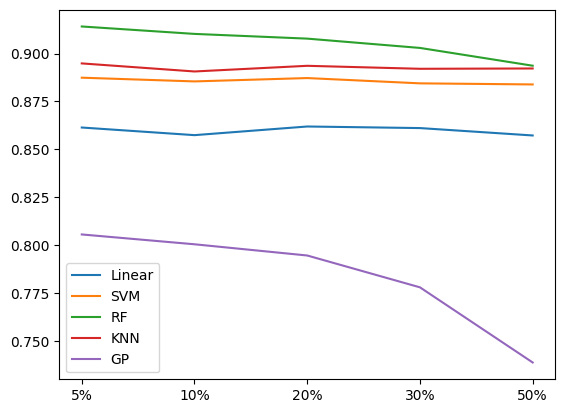

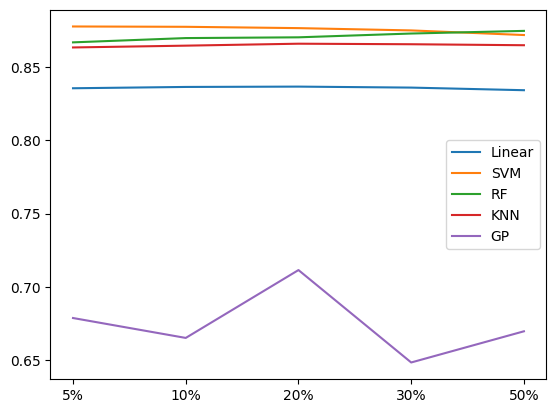

In [13]:
training_reduction_plot(r2_score_val.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])
training_reduction_plot(r2_score_test.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])

/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_81410/4151727328.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, temp], axis=0)


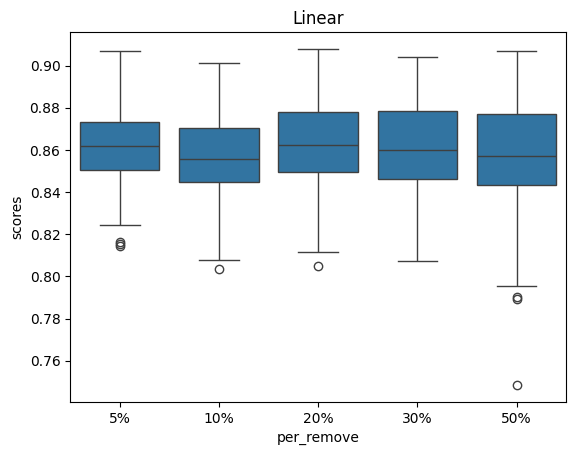

/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_81410/4151727328.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, temp], axis=0)


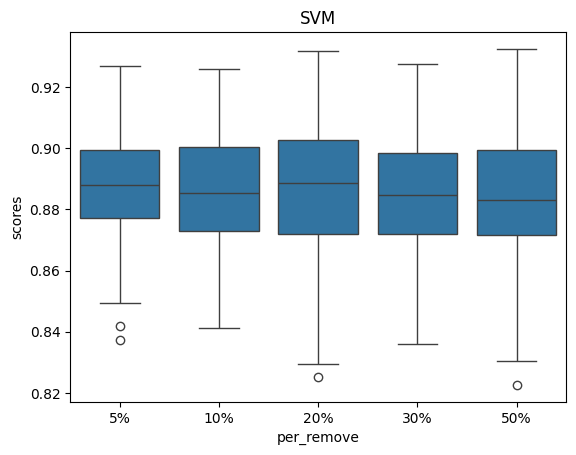

/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_81410/4151727328.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, temp], axis=0)


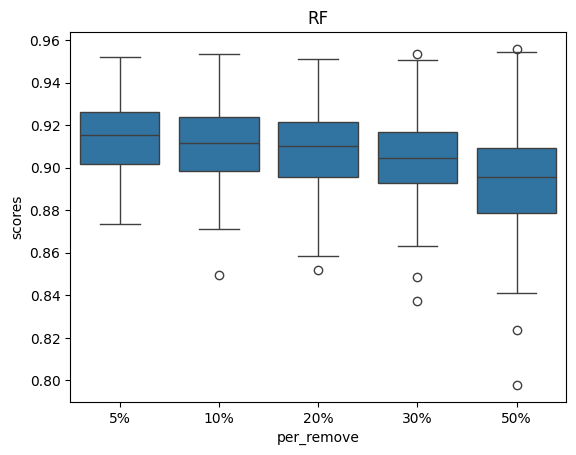

/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_81410/4151727328.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, temp], axis=0)


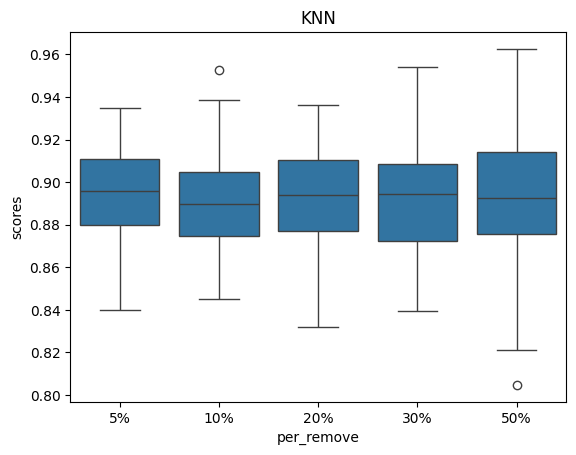

/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_81410/4151727328.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, temp], axis=0)


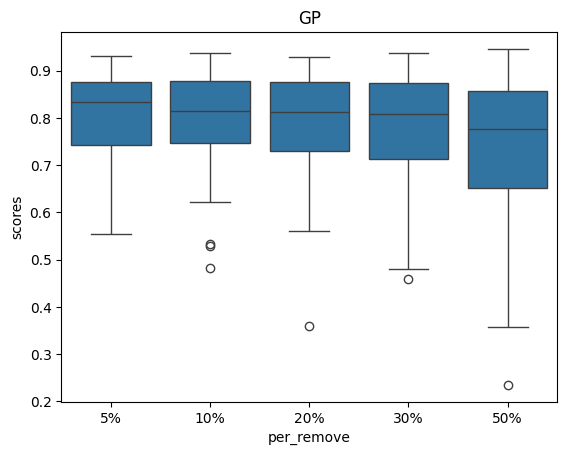

In [46]:
box_plot(r2_score_val.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])

In [ ]:
training_reduction_plot(r2_score_val.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])
training_reduction_plot(r2_score_test.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])

In [ ]:
plot_scores_distribution(r2_score_test.copy(), 'GP')
# plot_scores_distribution(r2_score_val.copy(), 'SVM')
# plot_scores_distribution(r2_score_val.copy(), 'RF')
# plot_scores_distribution(r2_score_val.copy(), 'KNN')

In [ ]:
# Plot KDEs with labels
model_name = 'RF'
sns.kdeplot(np.array(r2_score_test[5][model_name])[:,0], label='5%', color='r')
sns.kdeplot(np.array(r2_score_test[10][model_name])[:,0], label='10%', color='b')
sns.kdeplot(np.array(r2_score_test[20][model_name])[:,0], label='20%', color='g')
sns.kdeplot(np.array(r2_score_test[30][model_name])[:,0], label='30%', color='m')

# Add legend
plt.legend(title='Parameter', title_fontsize='13')

In [ ]:
sns.kdeplot(per_diff_test[5]['KNN'])
sns.kdeplot(per_diff_test[10]['Linear'])
sns.kdeplot(per_diff_test[20]['Linear'])
sns.kdeplot(per_diff_test[30]['Linear'])

In [ ]:
from pickle import dump

In [ ]:
# r2_score_val,  per_diff_val  = {}, {}
# r2_score_test, per_diff_test
with open('r2_score_val.pickle', 'wb') as f:
    dump(r2_score_val, f)

with open('per_diff_val.pickle', 'wb') as f:
    dump(per_diff_val, f)

with open('r2_score_test.pickle', 'wb') as f:
    dump(r2_score_test, f)

with open('per_diff_test.pickle', 'wb') as f:
    dump(per_diff_test, f)

In [25]:
pd.DataFrame({'values':[1,2,3], 'label':['a', 'b', 'c']}, columns=['values', 'label'])

,values,label
0,1,a
1,2,b
2,3,c
